<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/Tutorials/AtomicImagesCleaning_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Deep Neural Network for Locating Atoms in Noisy Atomically Resolved Images with PyTorch

**Prepared by Maxim Ziatdinov**

Contact e-mail: ziatdinovmax@gmail.com

In this notebook, I will show an example of how using PyTorch and simulated data to train a fully convolutional neural network for cleaning atomic images and enabling fast and easy atom finding. I will illustrate it using a training data for graphene lattice. Once the network is trained, it should be capable of generalizing to real experimental data.




---

Some important items:


*   The goal is to obtain a well-defined map of circular blobs on a uniform background in the output of our model. If a network is properly trained then the center of each blob in the predicted image should correspond to atomic (x, y) position.
*   To train our model, we are going to use simulated data for graphene with different atomic defects. The atomic coordinates come from density functional theory calculations (unpublished) of graphene with Si impurities under different tensile strain (~2-20%).
*  The atoms in the lattice are represented as 2d Gaussians. In principle we can also use Multislice simulations, but frankly I have not found much difference (especially for data with relatively high levels of noise) for one-atom-thick systems.
*  Here, all atoms will correspond to a single class. That said,  this analysis can be easily extended to a multi-class case (distinguishing between different chemical species). In the multi-class case, blobs in the ground truth corresponding to C atoms will have value 1, blobs corresponding to Si atoms will have value 2, etc.
*  Notice that alternatively one can use 2d Gaussians as ground truth instead of blobs. This apporach has been demonstrated by J. Madsen and co-workers (Advanced Theory and Simulations, 1(8), 2018). Based on some limited testing, I found that for noisy data both approaches seem to produce similar results, but the approach with blobs seem to be more effective for multi-class problems mentioned above (semantic segmentation).
* Once a model is trained it can in principle work with images of any resolution (as long as it can be divided by $2^n$ where *n* is a number of max-pooling layers used). However, there is always some optimal pixel-to-picometer ratio at which a network will work the best. I think in general it is always a good idea to determine such a ratio and (if possible) make adjustmentes to the resolution of experimental images.



## Import/install modules

Check NVIDIA's CUDA Compiler version (should be 9.0 or higher):

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


Install PyTorch (usually takes ~1 minute):

In [2]:
!pip3 install http://download.pytorch.org/whl/cu90/torch-1.0.0-cp36-cp36m-linux_x86_64.whl

    100% |████████████████████████████████| 591.8MB 53.2MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
fastai 1.0.46 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2


Check if PyTorch sees Colab's GPU:

In [3]:
import torch

try:
    device = torch.cuda.get_device_name(0)
    print('Available GPU:', str(device))
except RuntimeError:
    print('Please make sure you selected GPU as a hardware accelerator in Runtime --> Change runtime type')

Available GPU: Tesla K80


Import necessary modules:

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import time
import numpy as np
import h5py
import json
from sklearn.utils import shuffle
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt

%matplotlib inline

## Create a fully convolutional neural network

Let's start by constucting a deep (fully) convolutional neural network. First we write down new classes that will define several major blocks of a neural network, namely,  *conv2dblock* (convolutional layer followed by parametric ReLU activation with optional dropout (before activation) and/or batch normalization (after activation) layers), *dilated_layers* (sequence of atrous convolutions with different dilation rate, each activated by parametric ReLU, with optional dropouts and/or batch normaliztion) and *upsample_block* (upsampling either with a bilinear interpolation followed by one-by-one convolutional layer or with a transposed convolutional layer)

In [0]:
class conv2dblock(nn.Module):
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''Creates a block consisting of convolutional
        layer, leaky relu and (optionally) dropout and
        batch normalization
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output

class dilation_block(nn.Module):
    
    def __init__(self, input_channels, output_channels,
                 dilation_values, padding_values,
                 kernel_size=3, stride=1, lrelu_a=0.01,
                 use_batchnorm=False, dropout_=0):
        '''Creates a block with dilated convolutional
           layers (aka atrous convolutions)
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            dilation_values: list of dilation rates for convolution operation
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(dilation_block, self).__init__()
        atrous_module = []
        for idx, (dil, pad) in enumerate(zip(dilation_values, padding_values)):
            input_channels = output_channels if idx > 0 else input_channels
            atrous_module.append(nn.Conv2d(input_channels,
                                           output_channels,
                                           kernel_size=kernel_size,
                                           stride=stride,
                                           padding=pad,
                                           dilation=dil,
                                           bias=True))
            if dropout_ > 0:
                atrous_module.append(nn.Dropout(dropout_))
            atrous_module.append(nn.LeakyReLU(negative_slope=lrelu_a))
            if use_batchnorm:
                atrous_module.append(nn.BatchNorm2d(output_channels))
        self.atrous_module = nn.Sequential(*atrous_module)

    def forward(self, x):
        '''Forward path'''
        atrous_layers = []
        for conv_layer in self.atrous_module:
            x = conv_layer(x)
            atrous_layers.append(x.unsqueeze(-1))
        return torch.sum(torch.cat(atrous_layers, dim=-1), dim=-1)

class upsample_block(nn.Module):
    
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''Defines upsampling block performed either with
           bilinear interpolation followed by 1-by-1
           convolution or with a transposed convolution
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
        '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size=kernel_size,
            stride=stride, padding=padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

Now we create class *atomsegnet* for constructing a neural network for "atomic segmentation". A model in Pytorch is usually defined in two steps. First, we need to specify model parameters (we do it using `__init__` below), and then outline how they are applied to the inputs (i.e. `forward` path). Notice that in PyTorch we have to specify number of input and outpur channels and take care of image size padding (we cannot just use padding = 'same' like we can do in e.g. Keras). This formula will be very useful: 

`o = [i + 2*p - k - (k-1)*(d-1)]/s + 1`

o = output

p = padding

k = kernel_size

s = stride

d = dilation

Let's initialize our model. It will have a contracting path consisting of regular convolutional operations followed by max-pooling operation, a bottleneck layer with three layers of atrous convolutions with different dilation rates, and an expanding path with bilinear upsampling that has the same convolutional blocks as the contracting path but in a reversed order. The skip connections provide a flow of information between contracting and expanding pathes.The final layer provides a pixel-wise classification of the input data.

In [0]:
class atomsegnet(nn.Module):
    
    def __init__(self, nb_filters=32):
        '''Builds  a fully convolutional neural network model
        Args:
            nb_filters: number of filters in the first convolutional layer
        '''
        super(atomsegnet, self).__init__()
        self.c1 = conv2dblock(1, nb_filters)
        
        self.c2 = nn.Sequential(conv2dblock(nb_filters,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.c3 = nn.Sequential(conv2dblock(nb_filters*2,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.bn = dilation_block(nb_filters*4,
                                 nb_filters*8,
                                 dilation_values=[2, 4, 6],
                                 padding_values=[2, 4, 6],
                                 dropout_=0.5)
        
        self.upsample_block1 = upsample_block(nb_filters*8,
                                              nb_filters*4)
        
        self.c4 = nn.Sequential(conv2dblock(nb_filters*8,
                                            nb_filters*4,
                                            dropout_=0.3),
                                conv2dblock(nb_filters*4,
                                            nb_filters*4,
                                            dropout_=0.3))
        
        self.upsample_block2 = upsample_block(nb_filters*4,
                                              nb_filters*2)
        
        self.c5 = nn.Sequential(conv2dblock(nb_filters*4,
                                            nb_filters*2),
                                conv2dblock(nb_filters*2,
                                            nb_filters*2))
        
        self.upsample_block3 = upsample_block(nb_filters*2,
                                              nb_filters)
        
        self.c6 = conv2dblock(nb_filters*2,
                              nb_filters)
        
        self.px = nn.Conv2d(nb_filters,
                            1,
                            kernel_size=1,
                            stride=1,
                            padding=0)
               
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        c3 = self.c3(d2)
        d3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        # Atrous convolutions
        bn = self.bn(d3)
        # Expanding path
        u3 = self.upsample_block1(bn)
        u3 = torch.cat([c3, u3], dim=1)
        u3 = self.c4(u3)
        u2 = self.upsample_block2(u3)
        u2 = torch.cat([c2, u2], dim=1)
        u2 = self.c5(u2)
        u1 = self.upsample_block3(u2)
        u1 = torch.cat([c1, u1], dim=1)
        u1 = self.c6(u1)
        # pixel-wise classification
        px = self.px(u1)
        output = torch.sigmoid(px)
        return output

We can also visualize a model we have just constructed (entirely optional - feel free to skip this step and go directly to model compilation and training).

For model visualization, we'll need to install these modules (shouldn't take longer than ~30 seconds)

In [0]:
%%capture
!pip install -q pydot
!apt-get install graphviz -y
import pydot

In [0]:
%%capture
!pip install git+https://github.com/szagoruyko/pytorchviz

Now let's plot our model (note to self - next time give more interpretable names to different blocks and layers of a network)

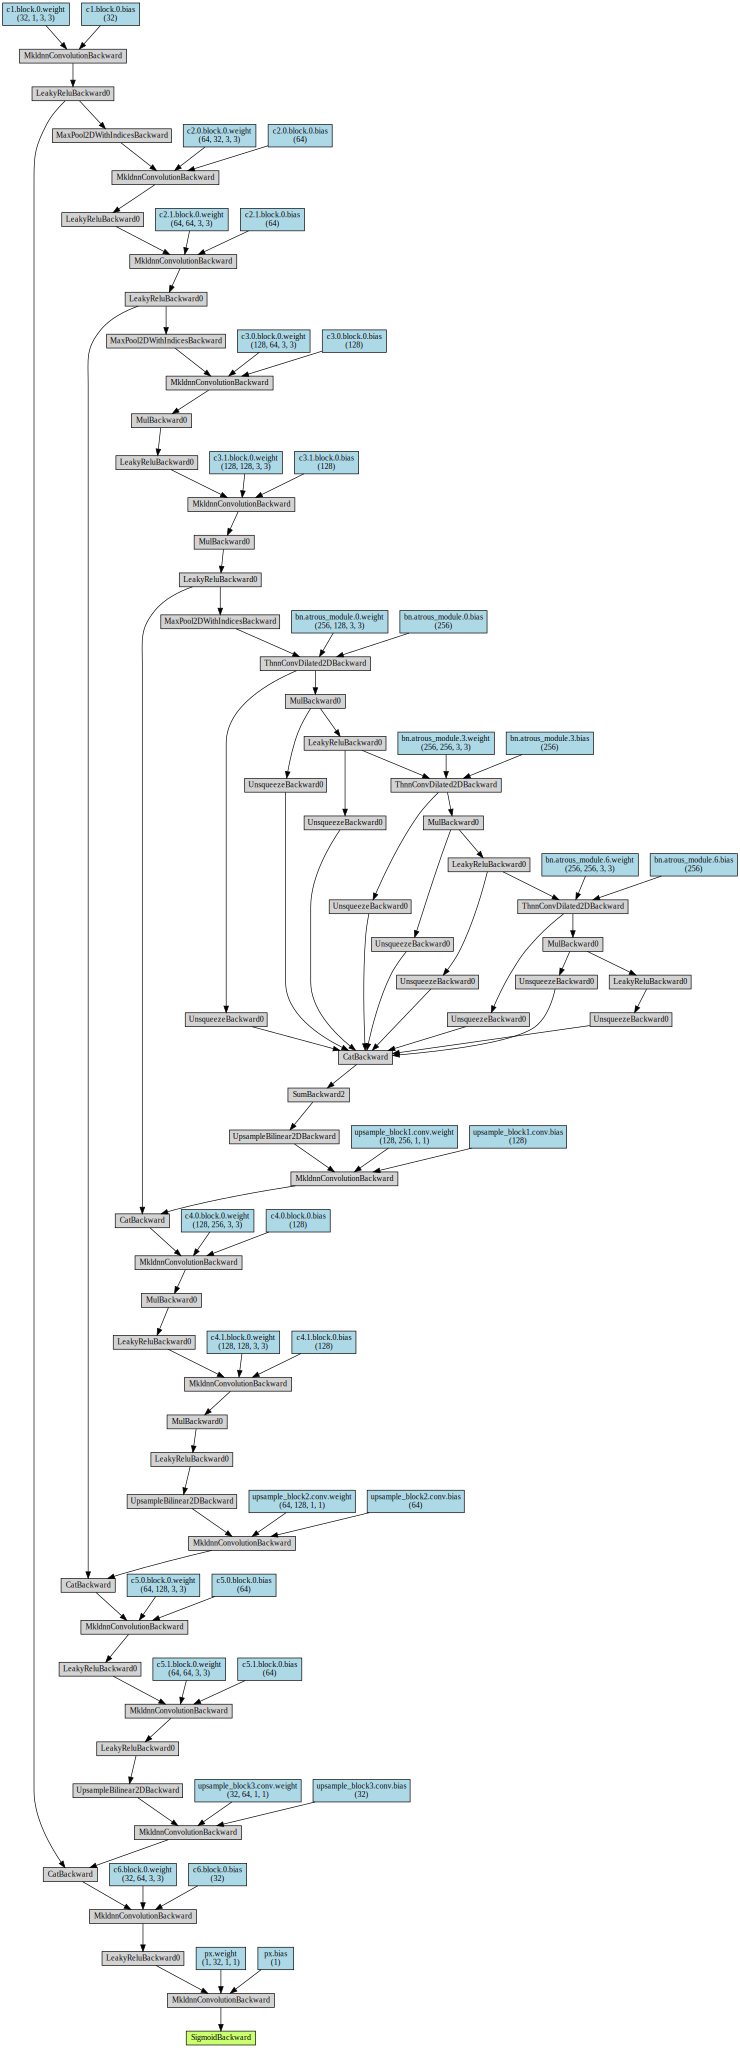

In [10]:
from torchviz import make_dot
model = atomsegnet()
x = torch.randn(1, 1, 256, 256).requires_grad_(False)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

Here we compile our model:

In [0]:
#initiate model and move it to GPU
model = atomsegnet()
model.cuda()
# specify loss function
criterion = nn.BCELoss()
# specify optimizer and learning rate (lr)
optimizer = optim.Adam(model.parameters(), lr = 5e-4)

## Load training data

We now create class *generate_batches* for feeding batches of training/test data into a neural network from a large hdf5 file. This assumes a simple hdf5 file structure where train/test images are stored as 'X_train'/'X_test' numpy arrays and corresponding groundtruth (labels) are stored as 'y_train/y_test' numpy arrays.

Notice that it also allows to change resolution of images within each batch during the training. From my experience, this may help your network to have more robust generalization abilities. This will work only if your network is fully convolutional (i.e. does not contain fully-connected, "dense", layers).

The cell below will download the hdf5 file with training data for this tutorial into the VM memory:

(may take several minutes)

In [12]:
!gdown https://drive.google.com/uc?id=1UW-8kCrV35bFUQ8WhBAREknwHF33pi8U

Downloading...
From: https://drive.google.com/uc?id=1UW-8kCrV35bFUQ8WhBAREknwHF33pi8U
To: /content/G-Si-DFT0_.hdf5
1.34GB [00:08, 160MB/s]


In [0]:
class generate_batches:
    
    def __init__(self, hf_file, batch_size, *args):
        '''Creates a batch generator.
        Args:
            hf_file: path to hdf5 file with training data
            batch_size: size of generated batch
            args: (tuple): image resizing during training (min_size, max_size, step)
        '''
        self.f = h5py.File(hf_file, 'r')
        self.batch_size = batch_size
        try:
            self.resize_ = args[0]
        except IndexError:
            self.resize_ = None
    
    def steps(self, mode = 'training'):
        """Estimates number of steps per epoch"""     
        if mode == 'val':
            n_samples = self.f['X_test'][:].shape[0]
        else:        
            n_samples = self.f['X_train'][:].shape[0]    
        return np.arange(n_samples//self.batch_size)
     
    def batch(self, idx, mode = 'training'):
        """Generates batch of the selected size
        for training images and the corresponding
        ground truth"""
        def batch_resize(X_batch, y_batch, rs):
            '''Resize all images in one batch'''

            if X_batch.shape[2:4] == (rs, rs):
                return X_batch, y_batch
            X_batch_r = np.zeros((X_batch.shape[0], X_batch.shape[1], rs, rs))
            y_batch_r = np.zeros((y_batch.shape[0], y_batch.shape[1], rs, rs)) 
            for i, (img, gt) in enumerate(zip(X_batch, y_batch)):
                img = cv2.resize(img[0], (rs, rs), cv2.INTER_CUBIC)
                img = np.expand_dims(img, axis = 0)
                gt = cv2.resize(gt[0], (rs, rs))
                gt = np.expand_dims(gt, axis = 0)
                X_batch_r[i, :, :, :] = img
                y_batch_r[i, :, :, :] = gt
            return X_batch_r, y_batch_r
    
        if mode == 'val':
            X_batch = self.f['X_test'][int(idx*self.batch_size):int((idx+1)*self.batch_size)]
            y_batch = self.f['y_test'][int(idx*self.batch_size):int((idx+1)*self.batch_size)]
        else:
            X_batch = self.f['X_train'][int(idx*self.batch_size):int((idx+1)*self.batch_size)]
            y_batch = self.f['y_train'][int(idx*self.batch_size):int((idx+1)*self.batch_size)]    
        if self.resize_ != None:
            rs_arr = np.arange(self.resize_[0], self.resize_[1], self.resize_[2])
            rs = np.random.choice(rs_arr)
            X_batch, y_batch = batch_resize(X_batch, y_batch, rs)
        X_batch = torch.from_numpy(X_batch).float()
        y_batch = torch.from_numpy(y_batch).float()
        yield X_batch, y_batch
    
    def close_(self):
        """Closes h5 file"""        
        if self.f:
            self.f.close()
            self.f = None

We are now going to train a model for finding and idenifying atoms in graphene. First we define a path to an hdf5 file with training/test data and a batch size:

In [0]:
# Training data filepath:
hf_file = 'G-Si-DFT0_.hdf5'
# batch size:
batch_size = 30

We can initialize a batch generator to produce a batch of training images with corresponding ground truth:

In [0]:
gen = generate_batches(hf_file, batch_size)
train_imgs, gt = next(gen.batch(30))
gen.close_()

We then can plot a training image - ground truth pair:

Text(0.5, 1.0, 'Ground truth')

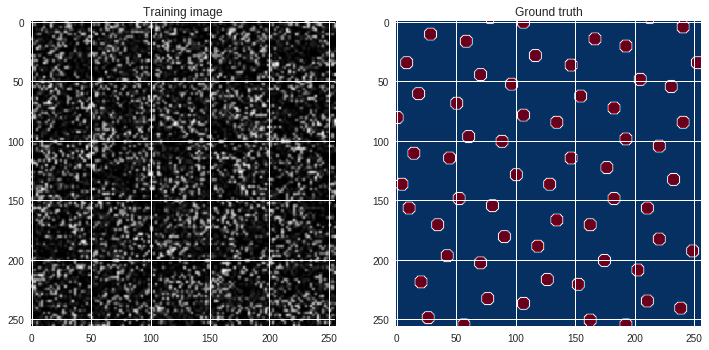

In [16]:
k = 1
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(121)
ax1.imshow(train_imgs[k, 0, :, :], cmap='gray')
ax1.set_title('Training image')
ax2 = fig.add_subplot(122)
ax2.imshow(gt[k, 0, :, :], cmap='RdBu_r', interpolation='Gaussian')
ax2.set_title('Ground truth')

## Model training

Finally, we train our model. We can change the size of images in each batch while training our model, which seems to lead to a model with a more robust generalization abilities.

In [17]:
# Choose number of training epochs
epochs = 120
# Lists for train/test history
train_losses, test_losses = [], []
# Initiate batch generator. Notice that we will be 
# randomly changing images size during the model training
gen = generate_batches(hf_file, batch_size, (256-128, 256+64+1, 32))
steps = gen.steps()
steps_val = gen.steps(mode = 'val')
# Train a model 
for e in range(epochs):    
    print("\nEpoch {}/{}".format(e+1, epochs)) 
    # Training mode
    model.train()
    running_loss_train = 0
    start = time.time()
    steps = shuffle(steps)
    for i, s in enumerate(steps):
        print("\rTraining mode", 4*".",
              "Batch {}/{}".format(i+1, len(steps)),
              end = "")
        # get image-ground truth pair
        images, labels = next(gen.batch(s))
        # transfer the pair to a gpu device
        images, labels = images.cuda(), labels.cuda() 
        # zero the parameter gradients
        optimizer.zero_grad() 
        # forward path
        prob = model.forward(images)
        # Calculate loss
        loss = criterion(prob, labels)
        running_loss_train += loss.item()
        # backward path
        loss.backward()
        # optimize
        optimizer.step()     
    # Evaluate current state on a validation set     
    else:
        time_per_batch = (time.time()-start)/len(steps)
        # Validation mode
        model.eval()
        running_loss_test = 0
        print()
        # disable gradient information
        with torch.no_grad():
            for i, s in enumerate(steps_val):
                print("\rValidation mode", 4*".",
                      "Batch {}/{}".format(i+1, len(steps_val)),
                      end = "")
                # Same as in training mode but without backprop
                images, labels = next(gen.batch(s, mode='val'))
                images, labels = images.cuda(), labels.cuda()
                prob = model.forward(images)
                loss = criterion(prob, labels)
                running_loss_test += loss.item()
        train_losses.append(running_loss_train/len(steps))
        test_losses.append(running_loss_test/len(steps_val)) 
        # print statistics        
        print("\nTraining loss: {:.4f}".format(train_losses[-1]),
             8*".", "Test loss: {:.4f}".format(test_losses[-1]),
             8*".", "Time per batch: {:.2f} {}".format(time_per_batch, "s"))
    # save model weights if validation loss has decreased
    if e > 0 and test_losses[e] < min(test_losses[:e]):
        print("Saving checkpoint weights...")
        torch.save(model.state_dict(), 'atomfinder-'+
                   hf_file.split('.')[0]+'-1-best_weights.pt')
    if e == epochs-1:
        print('\nFinished model training')
# save the final weights
torch.save(model.state_dict(), 'atomfinder-'+
           hf_file.split('.')[0]+'-1-final_weights.pt')
gen.close_()


Epoch 1/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.3416 ........ Test loss: 0.2805 ........ Time per batch: 2.22 s

Epoch 2/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.2451 ........ Test loss: 0.2108 ........ Time per batch: 2.14 s
Saving checkpoint weights...

Epoch 3/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.1784 ........ Test loss: 0.2194 ........ Time per batch: 1.90 s

Epoch 4/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.1654 ........ Test loss: 0.1757 ........ Time per batch: 1.92 s
Saving checkpoint weights...

Epoch 5/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.1596 ........ Test loss: 0.1628 ........ Time per batch: 2.11 s
Saving checkpoint weights...

Epoch 6/120
Training mode .... Batch 30/30
Validation mode .... Batch 11/11
Training loss: 0.1508 ........ Test loss: 0.18

Plot test/train losses vs. epochs:

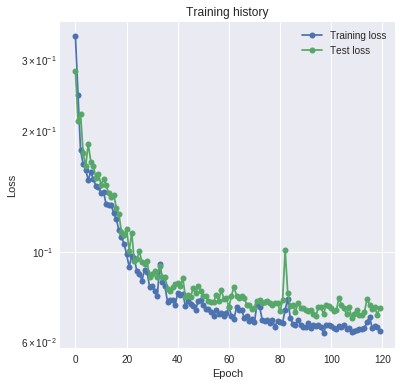

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(train_losses, '-o', label='Training loss', markersize=6)
ax.plot(test_losses, '-o', label='Test loss', markersize=6)
ax.set_title('Training history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')
ax.set_yscale('log')

## Test the trained model

Load saved weights back into our model:

In [0]:
# Load saved weights
filepath = 'atomfinder-G-Si-DFT0_-1-best_weights.pt'
checkpoint = torch.load(filepath, map_location='cpu')
# Initiate a model
model = atomsegnet()
# Load weights into the model
model.load_state_dict(checkpoint)

Generate a batch of validation data:

In [0]:
gen = generate_batches(hf_file, batch_size=10)
test_imgs, gt = next(gen.batch(10, mode='val'))
gen.close_()

Apply the trained model to the validation image(s) and compare a model's prediction to the ground truth:

In [0]:
# Pass test data through the network to make a prediction
prediction = model.forward(test_imgs)
# Torch variable --> numpy array
prediction = prediction.data.numpy()

Text(0.5, 1.0, 'Model prediction')

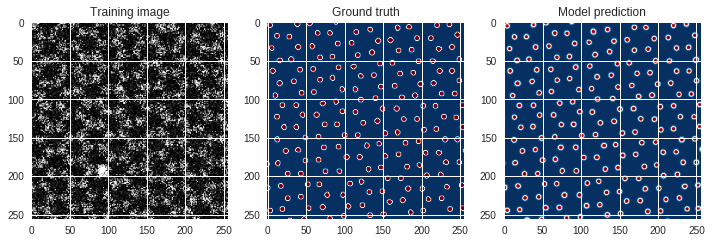

In [31]:
k = 4
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(131)
ax1.imshow(test_imgs[k, 0, :, :], cmap='gray')
ax1.set_title('Training image')
ax2 = fig.add_subplot(132)
ax2.imshow(gt[k, 0, :, :], cmap='RdBu_r', interpolation='Gaussian')
ax2.set_title('Ground truth')
ax3 = fig.add_subplot(133)
ax3.imshow(prediction[k, 0, :, :], cmap='RdBu_r', interpolation='Gaussian')
ax3.set_title('Model prediction')

Our model makes a good prediction, which is very close to ground truth. That said, it will be also very important to test it on the actual expermental data and see how it perfoms.